In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import math
import random
import os
import math

In [2]:
seq_len = 30           
batch_size = 32
epochs = 40
lr = 1e-3
seed = 42

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(seed)

Load data

In [5]:
from tabulate import tabulate

symbol = 'AMZN'
start_date = '2024-01-01'
end_date = '2024-12-31'

stock = yf.Ticker(symbol)
data = stock.history(start=start_date, end=end_date)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Historical Data for {symbol} from {start_date} to {end_date}")

formatted_data = pd.concat([data.head(), data.tail()])
print(tabulate(formatted_data, headers='keys', tablefmt='psql'))

print("\nShowing only the first and last 5 rows of data:")
print(tabulate(formatted_data, headers='keys', tablefmt='grid'))


Historical Data for AMZN from 2024-01-01 to 2024-12-31
+---------------------------+--------+--------+--------+---------+-------------+-------------+----------------+
| Date                      |   Open |   High |    Low |   Close |      Volume |   Dividends |   Stock Splits |
|---------------------------+--------+--------+--------+---------+-------------+-------------+----------------|
| 2024-01-02 00:00:00-05:00 | 151.54 | 152.38 | 148.39 |  149.93 | 4.73394e+07 |           0 |              0 |
| 2024-01-03 00:00:00-05:00 | 149.2  | 151.05 | 148.33 |  148.47 | 4.94255e+07 |           0 |              0 |
| 2024-01-04 00:00:00-05:00 | 145.59 | 147.38 | 144.05 |  144.57 | 5.60398e+07 |           0 |              0 |
| 2024-01-05 00:00:00-05:00 | 144.69 | 146.59 | 144.53 |  145.24 | 4.51531e+07 |           0 |              0 |
| 2024-01-08 00:00:00-05:00 | 146.74 | 149.4  | 146.15 |  149.1  | 4.67571e+07 |           0 |              0 |
| 2024-12-23 00:00:00-05:00 | 225.01 | 226.88 | 2

Preprocessing

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(data[['Close']].values)

In [7]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    X = np.array(X)   
    y = np.array(y)  
    return X, y

X, y = create_sequences(prices_scaled, seq_len)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (221, 30, 1) y shape: (221, 1)


Train / val split

In [8]:
n = len(X)
train_size = int(n * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

PyTorch Dataset

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TimeSeriesDataset(X_train, y_train)
val_ds = TimeSeriesDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

LSTM model

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, input_size)
    def forward(self, x):
        out, (hn, cn) = self.lstm(x) 
        last = out[:, -1, :]         
        out = self.fc(last)           
        return out
    
lstm_model = LSTMModel(input_size=1, hidden_size=64, num_layers=2, dropout=0.2).to(device)

1D CNN model

In [11]:
class CNN1DModel(nn.Module):
    def __init__(self, input_size=1, num_filters=64, kernel_size=3, seq_len=seq_len):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(num_filters)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(num_filters, num_filters//2, kernel_size=kernel_size, padding=kernel_size//2)
        self.pool = nn.AdaptiveAvgPool1d(1)  
        self.fc = nn.Linear(num_filters//2, input_size)
    def forward(self, x):
       
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)  
        x = x.squeeze(-1) 
        out = self.fc(x)  
        return out
cnn_model = CNN1DModel(input_size=1, num_filters=64, kernel_size=3).to(device)


Training

In [12]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for xb, yb in dataloader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    return running_loss / len(dataloader.dataset)

def eval_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            running_loss += loss.item() * xb.size(0)
    return running_loss / len(dataloader.dataset)

Train models 

In [13]:
def fit_model(model, train_loader, val_loader, epochs=epochs, lr=lr):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []
    for ep in range(1, epochs+1):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss = eval_epoch(model, val_loader, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if ep % 5 == 0 or ep == 1:
            print(f"Epoch {ep:03d}/{epochs}  Train: {train_loss:.4f}  Val: {val_loss:.4f}")
    history = {'loss': train_losses, 'val_loss': val_losses}
    return model, history

print("\nLSTM")
lstm_trained, history_lstm = fit_model(lstm_model, train_loader, val_loader, epochs=epochs, lr=lr)

print("\nCNN1D")
cnn_trained, history_cnn = fit_model(cnn_model, train_loader, val_loader, epochs=epochs, lr=lr)


LSTM
Epoch 001/40  Train: 0.2228  Val: 0.4894
Epoch 005/40  Train: 0.0116  Val: 0.1820
Epoch 010/40  Train: 0.0076  Val: 0.1247
Epoch 015/40  Train: 0.0069  Val: 0.1109
Epoch 020/40  Train: 0.0061  Val: 0.0968
Epoch 025/40  Train: 0.0050  Val: 0.0404
Epoch 030/40  Train: 0.0048  Val: 0.0227
Epoch 035/40  Train: 0.0041  Val: 0.0333
Epoch 040/40  Train: 0.0039  Val: 0.0165

CNN1D
Epoch 001/40  Train: 0.0805  Val: 0.4381
Epoch 005/40  Train: 0.0248  Val: 0.2858
Epoch 010/40  Train: 0.0099  Val: 0.0912
Epoch 015/40  Train: 0.0063  Val: 0.0479
Epoch 020/40  Train: 0.0045  Val: 0.0227
Epoch 025/40  Train: 0.0046  Val: 0.0247
Epoch 030/40  Train: 0.0032  Val: 0.0145
Epoch 035/40  Train: 0.0024  Val: 0.0162
Epoch 040/40  Train: 0.0026  Val: 0.0335


In [14]:
def predict(model, X):
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(X, dtype=torch.float32).to(device)
        preds = model(X_t).cpu().numpy()
    return preds

Predict and inverse transform

In [15]:
preds_lstm_scaled = predict(lstm_trained, X_val)
preds_cnn_scaled = predict(cnn_trained, X_val)

y_val_scaled = y_val

preds_lstm = scaler.inverse_transform(preds_lstm_scaled)
preds_cnn = scaler.inverse_transform(preds_cnn_scaled)
y_val_real = scaler.inverse_transform(y_val_scaled)

def rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

def mse(a, b):
    return mean_squared_error(a, b)

def mae(a, b):
    return mean_absolute_error(a, b)

print("\nValidation Metrics:")
print("LSTM:")
print(" RMSE:", rmse(preds_lstm, y_val_real))
print(" MSE:", mse(preds_lstm, y_val_real))
print(" MAE:", mae(preds_lstm, y_val_real))

print("CNN1D:")
print(" RMSE:", rmse(preds_cnn, y_val_real))
print(" MSE:", mse(preds_cnn, y_val_real))
print(" MAE:", mae(preds_cnn, y_val_real))


Validation Metrics:
LSTM:
 RMSE: 11.336304777426308
 MSE: 128.51180600669855
 MAE: 9.286180284288195
CNN1D:
 RMSE: 16.167977862476363
 MSE: 261.4035081615258
 MAE: 14.766486273871529


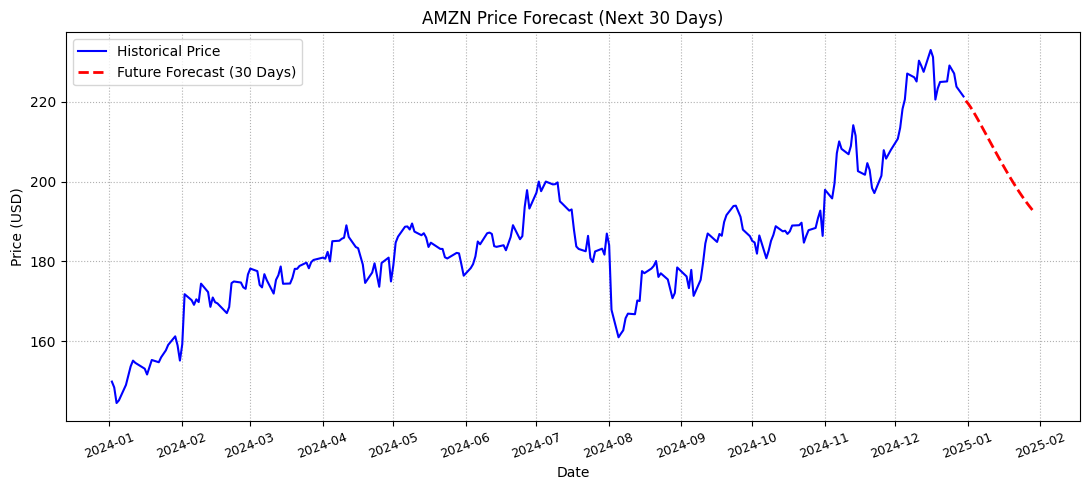

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# DỰ ĐOÁN 30 NGÀY
future_days = 30
last_window = prices_scaled[-seq_len:]
current_input = torch.tensor(last_window.reshape(1, seq_len, 1), dtype=torch.float32).to(device)

lstm_trained.eval()
future_scaled = []

with torch.no_grad():
    for _ in range(future_days):
        pred = lstm_trained(current_input)
        future_scaled.append(pred.item())
        # thêm giá trị mới vào
        new_input = torch.cat((current_input[:, 1:, :], pred.reshape(1, 1, 1)), dim=1)
        current_input = new_input

# Đưa về giá thật
future_scaled = np.array(future_scaled).reshape(-1, 1)
future_prices = scaler.inverse_transform(future_scaled).ravel()

# TẠO NGÀY TƯƠNG LAI
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='D')

# VẼ BIỂU ĐỒ
plt.figure(figsize=(11, 5))
plt.plot(data.index, data['Close'], color='blue', linewidth=1.5, label='Historical Price')
plt.plot(future_dates, future_prices, linestyle='--', color='red', linewidth=2, label='Future Forecast (30 Days)')
plt.title('AMZN Price Forecast (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.grid(True, linestyle=':')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=20, fontsize=9)
plt.tight_layout()
plt.show()
